In [ ]:
sc.stop()

In [ ]:
#Aktueller Code!:
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
import json

def main(timeout, func, window):

    sc = SparkContext("local", "Streaming-Exercise")
    ssc = StreamingContext(sc, window)
    stream = ssc.socketTextStream("127.0.0.1", 9999)
    
    func(stream)
    try:
        ssc.start()             
        ssc.awaitTerminationOrTimeout(timeout)  
    except Exception as e:
        print(str(e))
    finally:
        ssc.stop(False)

def print_json_stream(stream):
    stream.map(lambda x: json.loads(x)).pprint()


main(10, print_json_stream, 1)

/usr/local/spark/python/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


-------------------------------------------
Time: 2025-03-30 09:08:00
-------------------------------------------

-------------------------------------------
Time: 2025-03-30 09:08:01
-------------------------------------------
{'id': 1703328004, 'stationId': 8420, 'timestamp': '2025-03-02T16:23:46.500+01:00', 'confidence': 0.5519319772720337, 'probability': 0.3230060338973999, 'score': 7.0181149342224245, 'certainty': 'almost_certain', 'algorithm': 'BirdNET', 'metadata': None, 'species': {'id': 8, 'commonName': 'Long-tailed Tit', 'scientificName': 'Aegithalos caudatus', 'color': '#bdc706', 'imageUrl': 'https://media.birdweather.com/species/8/Long-tailedTit-standard-f8bdec5e2df87ccaa32a7b13a292f078.jpg', 'thumbnailUrl': 'https://media.birdweather.com/species/8/Long-tailedTit-thumbnail-652dd0fa7d32953de84a85963165fb57.jpg', 'pngUrl': 'https://media.birdweather.com/species/8/Long-tailedTit-png200-aba8917f8bf81c61c1bc7e2fe9f8aa63.png'}, 'lat': 47.533417, 'lon': 8.739937, 'soundscape': {'

In [ ]:
#Funktion die alle x Sekunden die vorkommenden Vögel aggregiert und ausgiebt.
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import json

def main(timeout, func, window):
    sc = SparkContext("local[*]", "Streaming-Aggregation")
    ssc = StreamingContext(sc, window)

    ssc.checkpoint("./checkpoint")

    stream = ssc.socketTextStream("127.0.0.1", 9999)
    func(stream)

    try:
        ssc.start()
        ssc.awaitTerminationOrTimeout(timeout)
    except Exception as e:
        print(str(e))
    finally:
        ssc.stop(False)

def aggregate_common_name(stream):
    def update_function(new_values, running_count):
        """Summiert neue Werte mit vorherigem Zustand."""
        return sum(new_values) + (running_count or 0)

    (stream
        .map(lambda x: json.loads(x))
        .map(lambda obj: (obj['species']['commonName'], 1))
        .updateStateByKey(update_function)
        .pprint()
    )

main(100, aggregate_common_name, 50)

/usr/local/spark/python/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


-------------------------------------------
Time: 2025-03-30 09:25:00
-------------------------------------------
('Long-tailed Tit', 1)
('House Sparrow', 20)
('Great Tit', 1)

-------------------------------------------
Time: 2025-03-30 09:25:50
-------------------------------------------
('Eurasian Blue Tit', 6)
('Great Spotted Woodpecker', 1)
('Eurasian Treecreeper', 1)
('Redwing', 1)
('Long-tailed Tit', 3)
('House Sparrow', 23)
('Great Tit', 21)
('Eurasian Magpie', 16)



In [ ]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import json

def main(timeout, func, window):
    sc = SparkContext("local[*]", "Streaming-Aggregation")
    ssc = StreamingContext(sc, window)

    ssc.checkpoint("./checkpoint")

    stream = ssc.socketTextStream("127.0.0.1", 9999)
    func(stream)

    try:
        ssc.start()
        ssc.awaitTerminationOrTimeout(timeout)
    except Exception as e:
        print(str(e))
    finally:
        ssc.stop(False)

def aggregate_common_name_with_image(stream):
    def update_function(new_values, running_state):
        """Summiert Vorkommen & speichert Bild-URL."""
        count = sum(v[0] for v in new_values) + (running_state[0] if running_state else 0)
        image_url = new_values[-1][1] if new_values else (running_state[1] if running_state else "")
        return (count, image_url)

    (stream
        .map(lambda x: json.loads(x))
        .map(lambda obj: (obj['species']['commonName'], (1, obj['species']['thumbnailUrl'])))
        .updateStateByKey(update_function)
        .map(lambda kv: (kv[0], f"Anzahl: {kv[1][0]}, Bild: {kv[1][1]}"))
        .pprint()
    )

main(30, aggregate_common_name_with_image, 5)

/usr/local/spark/python/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


-------------------------------------------
Time: 2025-03-30 09:28:25
-------------------------------------------

-------------------------------------------
Time: 2025-03-30 09:28:30
-------------------------------------------
('Long-tailed Tit', 'Anzahl: 1, Bild: https://media.birdweather.com/species/8/Long-tailedTit-thumbnail-652dd0fa7d32953de84a85963165fb57.jpg')
('House Sparrow', 'Anzahl: 3, Bild: https://media.birdweather.com/species/1/HouseSparrow-thumbnail-e9cbc91763a1579de8ef04880678b5e3.jpg')
('Great Tit', 'Anzahl: 1, Bild: https://media.birdweather.com/species/11/GreatTit-thumbnail-6910d0adae4550c5e6f2396322ee64c4.jpg')

-------------------------------------------
Time: 2025-03-30 09:28:35
-------------------------------------------
('Long-tailed Tit', 'Anzahl: 1, Bild: https://media.birdweather.com/species/8/Long-tailedTit-thumbnail-652dd0fa7d32953de84a85963165fb57.jpg')
('House Sparrow', 'Anzahl: 8, Bild: https://media.birdweather.com/species/1/HouseSparrow-thumbnail-e9cb

/usr/local/spark/python/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


📢 Eurasian Blue Tit: 3 mal erkannt


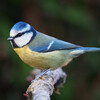

📢 Great Spotted Woodpecker: 1 mal erkannt


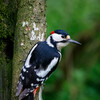

📢 Eurasian Treecreeper: 1 mal erkannt


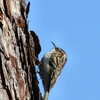

📢 Redwing: 1 mal erkannt


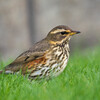

📢 Long-tailed Tit: 3 mal erkannt


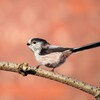

📢 House Sparrow: 23 mal erkannt


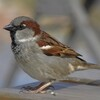

📢 Great Tit: 12 mal erkannt


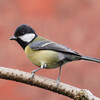

📢 Eurasian Magpie: 11 mal erkannt


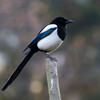

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import json
from IPython.display import display

def main(timeout, func, window):
    sc = SparkContext("local[*]", "Streaming-Aggregation")
    ssc = StreamingContext(sc, window)
    ssc.checkpoint("./checkpoint")
    stream = ssc.socketTextStream("127.0.0.1", 9999)
    func(stream)

    try:
        ssc.start()
        ssc.awaitTerminationOrTimeout(timeout)
    except Exception as e:
        print(str(e))
    finally:
        ssc.stop(False)


def show_image_from_url(url, species_name):

    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))

        display(img)
    except Exception as e:
        print(f"Fehler beim Laden des Bildes: {e}")

def aggregate_common_name_with_image(stream):
    def update_function(new_values, running_state):
        count = sum(v[0] for v in new_values) + (running_state[0] if running_state else 0)
        image_url = new_values[-1][1] if new_values else (running_state[1] if running_state else "")
        return (count, image_url)

    def show_images(rdd):

        results = rdd.collect()
        for species, (count, url) in results:
            print(f"📢 {species}: {count} mal erkannt")
            if url:
                show_image_from_url(url, species)

    (stream
        .map(lambda x: json.loads(x))
        .map(lambda obj: (obj['species']['commonName'], (1, obj['species']['thumbnailUrl'])))
        .updateStateByKey(update_function)
        .foreachRDD(show_images)
    )

main(100, aggregate_common_name_with_image, 100)
